# 2018-12-18 - Training on accute stimuli and seeing broad ones
Derrière ces jolis titres se cache l'idée de savoir comment va se passer la réponse du réseau si il apprend sur des stimulis précis (b_theta faible) puis qu'on lui montre des stimulis large (b_theta grand), avec la plasticité désactivé dans le second temps (ça mime un peu le phénomène de fenetre critique de plasticité en biologie en plus)

## D'aucun diraient que le bon terme c'était prédictive coding :-))

# Init

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True,
            seq_nbr= None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    #extracts the spiketrains
    
    #fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    
    #eye cancer-triggering lines
    sigma = out.best_values['sigma']

    
    if do_title :
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f'%sigma)
    
    return ax, sigma
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM
    

def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype = float)
        
        spiketrain_cut = np.where((spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]
        
        spiketrain_len.append(len(spiketrain_cut))
    
    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [3]:
def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        
        axs4 = plt.subplot(gs[0:1 , 4:6])
        axs5 = plt.subplot(gs[0:1 , 6:8])
        axs6 = plt.subplot(gs[1:2 , 4:6])
        axs7 = plt.subplot(gs[1:2 , 6:8])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(cut_spiketrain(SpikesP, 0), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 0) , axs4, seq_nbr = 1)[1]
        axs4.set_xticklabels([])
        axs4.set_yticklabels([])
        axs4.set_xlabel('')
        axs4.set_ylabel('')
        
        axs5.plot(cut_spiketrain(SpikesP, 1), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 1) , axs5, seq_nbr = 2)[1]
        axs5.set_xticklabels([])
        axs5.set_yticklabels([])
        axs5.set_xlabel('')
        axs5.set_ylabel('')
        
        axs6.plot(cut_spiketrain(SpikesP, 2), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 2) , axs6, seq_nbr = 3)[1]
        axs6.set_xticklabels([])
        axs6.set_yticklabels([])
        axs6.set_xlabel('')
        axs6.set_ylabel('')
        
        axs7.plot(cut_spiketrain(SpikesP, 3), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 3) , axs7, seq_nbr = 12)[1]
        axs7.set_xlabel('Neuron index')
        axs7.set_ylabel('Sequence spikes', rotation = 270)
        axs7.yaxis.tick_right()
        axs7.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig

# Hyperparameters

In [4]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 6000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 20  # degrees
b_theta = 30  # degrees
sparseness = .1

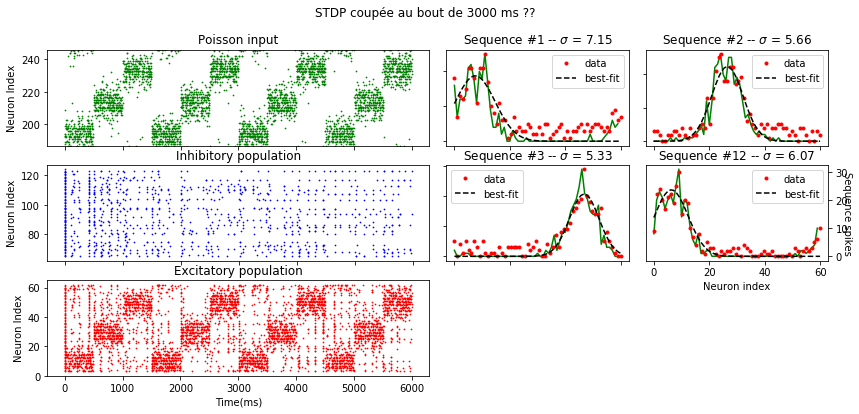

In [5]:
normal_weights = rnd('normal_clipped', mu=1.5, sigma=.2, low=0.1,
             high=5,
             rng=rng)

delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
             high=5,
             rng=rng)

timing_dependence=sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                    A_plus=1, A_minus=10)

stdp_weight_init = .5
stdp_max_w = 1

sim.setup(timestep=.1, threads=4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=500, duration=simtime, start=0),
                           label="Entree Orientation")

timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                      A_plus=1, A_minus=10)
inh_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                      A_plus=1, A_minus=10)

STDP_syn = sim.STDPMechanism(
    timing_dependence=timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
inh_STDP_syn = sim.STDPMechanism(
    timing_dependence=inh_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=inh_STDP_syn,
                             receptor_type='excitatory') #ACTUALLY INHIBITORY DUE TO STDP STRUCTURE

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_exc = sim.Projection(inh, exc,
                            connector=sim.FixedProbabilityConnector(
                                sparseness, rng=rng),
                            synapse_type=inh_STDP_syn,
                            receptor_type='excitatory') #ACTUALLY INHIBITORY DUE TO STDP STRUCTURE

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1),
                             receptor_type='excitatory')

def vary_angle(t):
    '''
    callback function that shifts the maximum angle
    '''
    
    simtime = 2000
    n_pop = 60
    shift = 40
 
    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])
        
    return t + simtime/4

angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime, callbacks=[vary_angle])
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig = SuperPlotter(inp_data, exc_data, inh_data,
             60, rates, simtime,
             title= 'STDP coupée au bout de 3000 ms ??',
             figsize = (14,6)
             )
#fit_plot(n_pop, exc_data)

plt.show()
#fig.savefig('./figs/2018_12_11_Optim_ring_inhSTDP+noise.pdf', format = 'pdf', dpi = 200)